In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp
import seaborn as sns

# Supplementary Packages
#import scipy.stats as stats
#import scipy.special as sps
#import time as t

# Guide
1. Over all time period<br>
* Use `twp4sc` to obtain pre-treatment period projection and post-treatment projection.
* Use `permutest4sc` to obtain a table of pre-treatment period distances and post-treatment period distances
* Use `permutest_by_timeperiod` to obtain table of distances over each time period
2. Weights averaged over time period
* Use `twp_by_timeperiod` to obtain projection and counterfactual distribution for each period
* Use `permutest_by_timeperiod` with `functiontype = 'each'`(default) to obtain table of distances over each time period
3. Weights over all time period but permutest by each time period
* Use `twp_singleweights` to obtain projection and counterfactual distribution for each period
* Use `permutest_by_timeperiod` with `functiontype = 'all'` to obtain table of distances over each time period
4. Plotting for by-period permutation tests
* Use `plot_byperiod_distances`

## Functions

In [2]:
def baryc_proj(source, target, method):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap).astype('float32')
    
    return(OTmap)

In [3]:
def DSCreplication(target, controls, method = 'emd', projtype = 'wass'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    S = np.mean(target)*n*d*J
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum_squares(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)], axis = 0))/S
                    )
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    
    weights = mylambda.value
    testproj = sum([a*b for a,b in zip(weights, G_list)])
    measureweights = [ot.unif(n)]*J #all barycprojs have same dimension
    
    if projtype == 'eucl':
        projection = testproj
    elif projtype == 'wass':
        projection = ot.lp.free_support_barycenter(G_list, measureweights, X_init = testproj, weights = weights)

    
    return(weights, projection)

In [4]:
# read data
# input: Target, pre_controls, post_controls, sample size, option to output weights
# output: projection pre-intervention, conterfactual distribution, optionally weights

def twp4sc(target, pre_controls, post_controls, samplesize = 'full', weight_out = False):
    
    if samplesize != 'full':
        
        # sample target
        target = np.array(
                    pd.DataFrame(target).sample(samplesize, random_state = 31))
        
        # sample controls
        for i in range(len(pre_controls)):
            pre_controls[i] = np.array(
                                pd.DataFrame(
                                    pre_controls[i]).sample(samplesize, random_state = 31))
            
        for j in range(len(post_controls)):
            post_controls[j] = np.array(
                                pd.DataFrame(
                                    post_controls[j]).sample(samplesize, random_state = 31))
        
    # TWP
    lambdas, projection = DSCreplication(target, pre_controls)
        
    # counterfactual distribution
    n = post_controls[0].shape[0]
    d = post_controls[0].shape[1]
    J = len(post_controls)
    
    measureweights = [ot.unif(n)]*J # check if post controls can have different length
    x_init = np.random.normal(0., 1., (n, d))
        
    cntfctl = ot.lp.free_support_barycenter(post_controls, measureweights, X_init = x_init, weights = lambdas)
        
    if weight_out:
        return(lambdas, projection, cntfctl)
    else:
        return(projection, cntfctl)

In [5]:
# input: list of target and controls pre and post intervention
# output: lists of distances between actual and replication

def permutest4sc(PRE, POST, samplesize = 'full'):
    
    pre_dists = []
    post_dists = []

    for i in range(len(PRE)):

        pre_projection, post_projection = twp4sc(PRE[i], PRE[:i]+PRE[i+1:], POST[:i]+POST[i+1:], samplesize)

        n1 = pre_projection.shape[0]
        n2 = post_projection.shape[0]
        
        # distance to pre
        if samplesize != 'full':
                current_pre = np.array(
                                pd.DataFrame(
                                    PRE[i]).sample(samplesize, random_state = 31))
        else: current_pre = PRE[i]
                
        M1 = ot.dist(pre_projection, current_pre)
        a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n1,)) / n1
        dist2pre = ot.emd2(a_ones, b_ones, M1)
        pre_dists.append(dist2pre)

        
        # distance to post
        if samplesize != 'full':
                current_post = np.array(
                                pd.DataFrame(
                                    POST[i]).sample(samplesize, random_state = 31))
        else: current_post = POST[i]
            
        M2 = ot.dist(post_projection, current_post)
        a_ones, b_ones = np.ones((n2,)) / n2, np.ones((n2,)) / n2
        dist2post = ot.emd2(a_ones, b_ones, M2)
        post_dists.append(dist2post)
                
            
    return(pre_dists, post_dists)

#### Time Period option

In [6]:
# input: list of target(np.arrays), list of list of controls(arrays), pre and post - each element is one time period

def twp_by_timeperiod(targets, pre_controls, post_controls, weighting = 'uniform', samplesize = 100):
    
    # restructure controls
    pre_set = []
    for j in range(len(pre_controls[0])):
        tmp = [pre_controls[i][j] for i in range(len(pre_controls))]
        pre_set.append(tmp)
        
    post_set = []
    for j in range(len(post_controls[0])):
        tmp = [post_controls[i][j] for i in range(len(post_controls))]
        post_set.append(tmp)
        
        
    # i is time period
    lambdas = []
    projections = []
    for i in range(len(targets)):
        
        if samplesize != 'full':
        
        # sample target
            target = np.array(
                        pd.DataFrame(targets[i]).sample(samplesize, random_state = 31))
        
        # sample controls
            controls = []
            for j in range(len(pre_set[i])):
                controls.append(np.array(
                                        pd.DataFrame(
                                            pre_set[i][j]).sample(samplesize, random_state = 31)))
        else:
            target = targets[i]
            controls = controls_temp[i]
        
        lam, projection = DSCreplication(target, controls)
        lambdas.append(lam)
        projections.append(projection)
        # projections are still from yearly weights -- make function that manually takes in custom weights
    
    lambdas = np.array(lambdas)
    
    if weighting == 'uniform':
        opt_lambdas = np.mean(lambdas, axis = 0)
    else:
        opt_lambdas = [a*b for a,b in zip(weighting, lambdas)]

    
    
    #Post
    cntfctl = []
    for i in range(len(post_set)):
        
        if samplesize != 'full':
        
            # sample controls
            sampled_controls = []
            for j in range(len(post_set[i])):
                sampled_controls.append(np.array(
                                        pd.DataFrame(
                                            post_set[i][j]).sample(samplesize, random_state = 31)))
                
        else: sampled_controls = post_set
        
        n = sampled_controls[0].shape[0]
        d = sampled_controls[0].shape[1]
        J = len(sampled_controls)

        measureweights = [ot.unif(n)]*J # check if post controls can have different length
        x_init = np.random.normal(0., 1., (n, d))
    
        cntfctl.append(
                ot.lp.free_support_barycenter(sampled_controls, measureweights, 
                                                  X_init = x_init, weights = opt_lambdas))
    
    return(opt_lambdas, projections, cntfctl)

In [7]:
def permutest_by_timeperiod(PRE, POST, functiontype = 'each', weighting = 'uniform', samplesize = 100):
    
    
    PRE_D = []
    POST_D = []
    for j in range(len(PRE)): # j is index for each distribution
        
        if functiontype == 'each' :
            weights, pre_p, post_p = twp_by_timeperiod(PRE[j], 
                                                        PRE[:j]+PRE[j+1:], 
                                                        POST[:j]+POST[j+1:], 
                                                        weighting = weighting,
                                                        samplesize = samplesize)

        elif functiontype == 'all':
            weights, pre_p, post_p = twp_singleweights(PRE[j], 
                                                        PRE[:j]+PRE[j+1:], 
                                                        POST[:j]+POST[j+1:], samplesize = samplesize)
        else:
            raise Warning('Unrecognized function type')
            
            
        # distance to pre
        pre_dists = []

        for k in range(len(PRE[j])): # k is year
            
            current_pre = np.array(
                            pd.DataFrame(PRE[j][k]).sample(samplesize, random_state = 31))
            n = current_pre.shape[0]
            M = ot.dist(pre_p[k], current_pre)
            a_ones, b_ones = np.ones((n,)) / n, np.ones((n,)) / n
            dist2pre = ot.emd2(a_ones, b_ones, M)
            pre_dists.append(dist2pre)
        
        
        # distance to post
        post_dists = []

        for l in range(len(POST[j])): # k is year
            
            current_post = np.array(
                            pd.DataFrame(POST[j][l]).sample(samplesize, random_state = 31))
            n = current_post.shape[0]
            M = ot.dist(post_p[l], current_post)
            a_ones, b_ones = np.ones((n,)) / n, np.ones((n,)) / n
            dist2post = ot.emd2(a_ones, b_ones, M)
            post_dists.append(dist2post)
        
        PRE_D.append(pre_dists)
        POST_D.append(post_dists)
            
    return(PRE_D, POST_D)

In [8]:
# plotting function
# inputs: 2 outputs of the permutation_by_timeperiod function and vector of time periods
# output: plots

def plot_byperiod_distances(pre_d, post_d, timeperiods):
    
    byperiod = pd.concat([pd.DataFrame(pre_d), pd.DataFrame(post_d)], axis = 1)
    byperiod.columns = timeperiods
    
    for i in range(len(pre_d) - 1):
        plt.plot(byperiod.iloc[i,:], 'bo-')
        
    #actual target    
    plt.plot(byperiod.iloc[len(pre_d) - 1], 'o-', color = 'orange')

### allperiod weights

In [9]:
# input: list of target(np.arrays), list of list of controls(arrays), pre and post - each element is one time period
# during the first step, we merge all periods into one dataset and sample, and then calculate optimal weights

def twp_singleweights(targets, pre_controls, post_controls, samplesize = 100):
    
    allperiodtarget = np.concatenate(targets)
    target = np.array(
                    pd.DataFrame(allperiodtarget).sample(samplesize, random_state = 31))
    
    controls = []
    for k in range(len(pre_controls)):
        allperiodcontrol = np.concatenate(pre_controls[k])
        controls.append(np.array(
                            pd.DataFrame(allperiodcontrol).sample(samplesize, random_state = 31)))
     
    # get weights
    opt_lambdas, _ = DSCreplication(target, controls)
    
    
    # restructure controls
    pre_set = []
    for j in range(len(pre_controls[0])):
        tmp = [pre_controls[i][j] for i in range(len(pre_controls))]
        pre_set.append(tmp) 
        
    post_set = []
    for j in range(len(post_controls[0])):
        tmp = [post_controls[i][j] for i in range(len(post_controls))]
        post_set.append(tmp)
        
        
    # i is time period
    projections = []
    for i in range(len(pre_set)):
        
        if samplesize != 'full':
        
            # sample controls
            sampled_controls = []
            for j in range(len(pre_set[i])):
                sampled_controls.append(np.array(
                                        pd.DataFrame(
                                            pre_set[i][j]).sample(samplesize, random_state = 31)))
                
        else: sampled_controls = pre_set
        
        n = sampled_controls[0].shape[0]
        d = sampled_controls[0].shape[1]
        J = len(sampled_controls)

        measureweights = [ot.unif(n)]*J # check if post controls can have different length
        x_init = np.random.normal(0., 1., (n, d))
    
        projections.append(
                ot.lp.free_support_barycenter(sampled_controls, measureweights, 
                                                  X_init = x_init, weights = opt_lambdas))
        
    
    #Post
    cntfctl = []
    for i in range(len(post_set)):
        
        if samplesize != 'full':
        
            # sample controls
            sampled_controls = []
            for j in range(len(post_set[i])):
                sampled_controls.append(np.array(
                                        pd.DataFrame(
                                            post_set[i][j]).sample(samplesize, random_state = 31)))
                
        else: sampled_controls = post_set
        
        n = sampled_controls[0].shape[0]
        d = sampled_controls[0].shape[1]
        J = len(sampled_controls)

        measureweights = [ot.unif(n)]*J # check if post controls can have different length
        x_init = np.random.normal(0., 1., (n, d))
    
        cntfctl.append(
                ot.lp.free_support_barycenter(sampled_controls, measureweights, 
                                                  X_init = x_init, weights = opt_lambdas))
    
    return(opt_lambdas, projections, cntfctl)

## Test Data

In [10]:
def read_medicaid(file_name, columns, samplesize = 'full'):
    
    df = pd.read_csv(file_name)[columns]
    
    if samplesize != 'full':
        df = df.sample(samplesize, random_state = 31)
    
    return(np.array(df))

In [11]:
columns1 = ['HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']

#pre
testtarget = read_medicaid('workingData/medicaid/MT.csv', columns1)

testcontrol1 = read_medicaid('workingData/medicaid/AL.csv', columns1)
testcontrol2 = read_medicaid('workingData/medicaid/FL.csv', columns1)
testcontrol3 = read_medicaid('workingData/medicaid/GA.csv', columns1)
testcontrols = [testcontrol1, testcontrol2, testcontrol3]

#post
posttarget = read_medicaid('workingData/medicaid/Counterfactual/MT_post.csv', columns1)

testpost1 = read_medicaid('workingData/medicaid/Counterfactual/AL_post.csv', columns1)
testpost2 = read_medicaid('workingData/medicaid/Counterfactual/FL_post.csv', columns1)
testpost3 = read_medicaid('workingData/medicaid/Counterfactual/GA_post.csv', columns1)
testpost = [testpost1, testpost2, testpost3]


In [12]:
w, a, b = twp4sc(testtarget, testcontrols, testpost, samplesize = 100, weight_out = True)
a[:,0:2] = a[:,0:2].round(decimals = 0).astype('int32')
print(a[0:5,])

[[ 1.          1.          3.07371714  8.02004536]
 [ 1.          1.          4.5784871  12.39123194]
 [ 1.          1.          3.95016683 11.66769274]
 [ 1.          1.          3.72924324 10.20876597]
 [ 1.          1.          3.96144264 10.76469223]]


In [13]:
b[:,0:2] = b[:,0:2].round(decimals = 0).astype('int32')
print(b[0:5,])

[[ 1.          1.          4.60225682 12.89783065]
 [ 1.          1.          4.8152887  11.1268552 ]
 [ 1.          1.          1.83738505  9.60803419]
 [ 1.          1.          3.0220022   9.5623157 ]
 [ 2.          1.          4.40207383 10.56737765]]


# Permutation Test

In [14]:
# make list of target+controls
pre = testcontrols
pre.append(testtarget)
post = testpost
post.append(posttarget)

c,d = permutest4sc(pre, post, 100)

In [15]:
# last row is the distances for our true target distribution

res = pd.concat((pd.DataFrame(c), pd.DataFrame(d)),axis =1)
res.columns = ['pre', 'post']
print(res)

        pre      post
0  0.306481  0.332038
1  0.224178  0.322763
2  0.198738  0.220604
3  0.516337  0.291913


* output is by time-period

# TIME PERIOD

In [16]:
def timeperiod_split(data, start, length):
    
    df = pd.DataFrame(data)
    df.columns = columns2
    output = []
    for i in range(length):
        temp = df[df['YEAR'] == start + i].drop(columns = ['YEAR'])
        output.append(np.array(temp))
    
    return(output)   

In [17]:
columns2 = ['YEAR','HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']

#pre
testtarget2 = read_medicaid('workingData/medicaid/MT.csv', columns2)

testcontrol1 = read_medicaid('workingData/medicaid/AL.csv', columns2)
testcontrol2 = read_medicaid('workingData/medicaid/FL.csv', columns2)
testcontrol3 = read_medicaid('workingData/medicaid/GA.csv', columns2)

targetTP = timeperiod_split(testtarget2, 2010, 7)
controlTP1 = timeperiod_split(testcontrol1, 2010, 7)
controlTP2 = timeperiod_split(testcontrol2, 2010, 7)
controlTP3 = timeperiod_split(testcontrol3, 2010, 7)

pre_controls = [controlTP1, controlTP2, controlTP3]
PREtp = [controlTP1, controlTP2, controlTP3, targetTP] #for permutest

    
#post
posttarget2 = read_medicaid('workingData/medicaid/Counterfactual/MT_post.csv', columns2)

testpost1 = read_medicaid('workingData/medicaid/Counterfactual/AL_post.csv', columns2)
testpost2 = read_medicaid('workingData/medicaid/Counterfactual/FL_post.csv', columns2)
testpost3 = read_medicaid('workingData/medicaid/Counterfactual/GA_post.csv', columns2)

post_targetTP = timeperiod_split(posttarget2, 2017, 4)
post_controlTP1 = timeperiod_split(testpost1, 2017, 4)
post_controlTP2 = timeperiod_split(testpost2, 2017, 4)
post_controlTP3 = timeperiod_split(testpost3, 2017, 4)

post_controls = [post_controlTP1, post_controlTP2, post_controlTP3]
POSTtp = [post_controlTP1, post_controlTP2, post_controlTP3, post_targetTP] #for permutest

In [18]:
w, p, c = twp_by_timeperiod(targetTP, pre_controls, post_controls, samplesize = 100)

In [19]:
# we omit the rounding step for now

print(w)
print(p[0][0:5,])
print(c[0][0:5,])

[0.40290848 0.16890648 0.42818504]
[[ 1.          1.          4.5822545  11.708668  ]
 [ 1.          1.          1.53043306  8.65272299]
 [ 1.          1.          3.33194724 10.0317215 ]
 [ 1.          1.          3.83855426  9.66845871]
 [ 1.          1.          3.77864971 10.98461092]]
[[ 1.          1.          3.92001689 11.03522492]
 [ 1.          1.          3.80790129 10.81254615]
 [ 1.          1.          4.67998919 11.81212128]
 [ 1.          1.          2.9738554   9.34392782]
 [ 1.          1.          4.01782177 12.21157246]]


In [20]:
pred,postd = permutest_by_timeperiod(PREtp, POSTtp, functiontype = 'each', samplesize = 100)

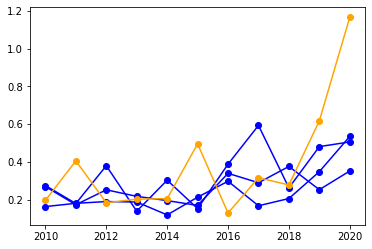

In [21]:
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
plot_byperiod_distances(pred, postd, years)

## Weights over all periods, permutest over each period

In [22]:
w2, p2, c2 = twp_singleweights(targetTP, pre_controls, post_controls, samplesize = 100)

In [23]:
# we omit the rounding step for now

print(w2)
print(p2[0][0:5,])
print(c2[0][0:5,])

[0.79314211 0.02720102 0.17965688]
[[ 1.          1.          5.19577094 12.03188139]
 [ 1.          1.          3.80037164 10.54346757]
 [ 1.          1.          3.43869477  9.31563351]
 [ 1.          1.          3.77054771  8.64799095]
 [ 1.          1.          3.4497411  10.08952997]]
[[ 1.          1.          1.9969495   8.53445427]
 [ 1.97279898  1.          1.94839164  8.63718023]
 [ 1.          1.          2.94012506 10.26948118]
 [ 1.          1.          3.83450796 10.94552597]
 [ 1.          1.          4.04680165 11.44823329]]


In [24]:
pred2,postd2 = permutest_by_timeperiod(PREtp, POSTtp, functiontype = 'all', samplesize = 100)

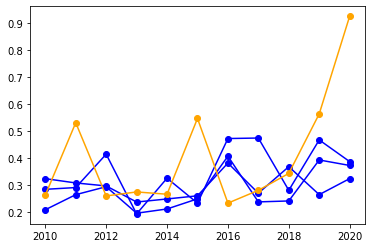

In [25]:
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
plot_byperiod_distances(pred2, postd2, years)